In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy import array
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error


In [53]:
stock_apple = pd.read_csv('Apple_clean.csv')
stock_apple

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-12-31,7.611786,7.619643,7.520000,7.526071,6.326138,352410800
1,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.424604,493729600
2,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.435713,601904800
3,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.333343,552160000
4,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.321635,477131200
...,...,...,...,...,...,...,...
3977,2025-10-23,259.940002,260.619995,258.010010,259.579987,259.579987,32754900
3978,2025-10-24,261.190002,264.130005,259.179993,262.820007,262.820007,38253700
3979,2025-10-27,264.880005,269.119995,264.649994,268.809998,268.809998,44888200
3980,2025-10-28,268.989990,269.890015,268.149994,269.000000,269.000000,41461500


In [54]:
stock_apple['Date'] = pd.to_datetime(stock_apple['Date'])
stock_apple = stock_apple.set_index(pd.DatetimeIndex(stock_apple['Date'].values))
df_apple = pd.DataFrame(stock_apple, columns=['Close'])


In [55]:
scaler = MinMaxScaler(feature_range=(0,1))
df_apple_scaled = scaler.fit_transform(np.array(df_apple).reshape(-1,1))

In [56]:
train_size = int(len(df_apple_scaled) * 0.7)
val_size = int(len(df_apple_scaled) * 0.1)
test_size = len(df_apple_scaled) - train_size - val_size

train_data = df_apple_scaled[:train_size]
val_data = df_apple_scaled[train_size:train_size+val_size]
test_data = df_apple_scaled[train_size+val_size:]

In [57]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 100

In [58]:
train_last_window = train_data[-time_step:]
val_data_extended = np.concatenate((train_last_window, val_data), axis=0)
val_last_window = val_data[-time_step:]
test_data_extended = np.concatenate((val_last_window, test_data), axis=0)

X_train, y_train = create_dataset(train_data, time_step)
X_val, y_val = create_dataset(val_data_extended, time_step)
X_test, y_test = create_dataset(test_data_extended, time_step)

In [59]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [60]:
from keras.layers import Input

model = Sequential()
# Dùng Input ở layer đầu tiên
model.add(Input(shape=(time_step, 1)))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='relu'))
model.compile(loss='mean_squared_error', optimizer='adam')

In [61]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,        # Số epoch bạn muốn train
    batch_size=32,    # batch size
    verbose=1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

Epoch 1/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 14s 99ms/step - loss: 0.0011 - val_loss: 6.0692e-04
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - loss: 2.0964e-04 - val_loss: 7.3895e-04
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - loss: 1.9323e-04 - val_loss: 0.0018
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - loss: 1.7304e-04 - val_loss: 4.8919e-04
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - loss: 1.4894e-04 - val_loss: 4.2394e-04
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - loss: 1.6129e-04 - val_loss: 4.5056e-04
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - loss: 1.2972e-04 - val_loss: 7.4253e-04
Epoch 8/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - loss: 1.3850e-04 - val_loss: 3.6659e-04
Epoch 9/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - loss: 1.3202e-04 - val_loss: 3.7885e-04
Epoch 10/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - loss: 1.3058e-04 - val_loss: 5.1182e-04
Epoch 11/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - loss: 1.5785e-04 - va

In [62]:
y_pred_test = model.predict(X_test)
y_pred_val = model.predict(X_val)

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


In [63]:
val_mape = mean_absolute_percentage_error(y_pred_val, y_val)
val_mse = mean_squared_error(y_pred_val, y_val)
val_rmse = np.sqrt(val_mse)
val_msle = mean_squared_log_error(y_pred_val, y_val)
print(f"Validation MAPE: {val_mape}")
print(f"Validation RMSE: {val_rmse}")
print(f"Validation MSLE: {val_msle}")

Validation MAPE: 0.021155432992454
Validation RMSE: 0.015056149083366098
Validation MSLE: 9.359887230229005e-05


In [64]:
test_mape = mean_absolute_percentage_error(y_pred_test, y_test)
test_mse = mean_squared_error(y_pred_test, y_test)
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(y_pred_test, y_test)
print(f"Test MAPE: {test_mape}")
print(f"Test RMSE: {test_rmse}")
print(f"Test MSLE: {test_msle}")

Test MAPE: 0.02050733966061599
Test RMSE: 0.019740741472342567
Test MSLE: 0.00012955042037495878


In [65]:
x_input = test_data[5:].reshape(1,-1)
temp_input = list(x_input[0])
prediction_next30_days = []

for i in range(30):
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[-time_step:])
        x_input = x_input.reshape((1, time_step, 1))
        y_hat = model.predict(x_input, verbose=0)
        temp_input.extend(y_hat[0].tolist())
        prediction_next30_days.extend(y_hat.tolist())
    else:
        x_input = np.array(temp_input).reshape((1, time_step, 1))
        y_hat = model.predict(x_input, verbose=0)
        temp_input.extend(y_hat[0].tolist())
        prediction_next30_days.extend(y_hat.tolist())

In [66]:
last_date = stock_apple.index.max()
future_dates = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=30, freq='D')

In [67]:
prediction_next30_days = scaler.inverse_transform(prediction_next30_days).reshape(-1)
y_pred_test = scaler.inverse_transform(y_pred_test)
y_pred_val = scaler.inverse_transform(y_pred_val)
train_data_inv = scaler.inverse_transform(train_data) 
val_data_inv = scaler.inverse_transform(val_data)
test_data_inv = scaler.inverse_transform(test_data)

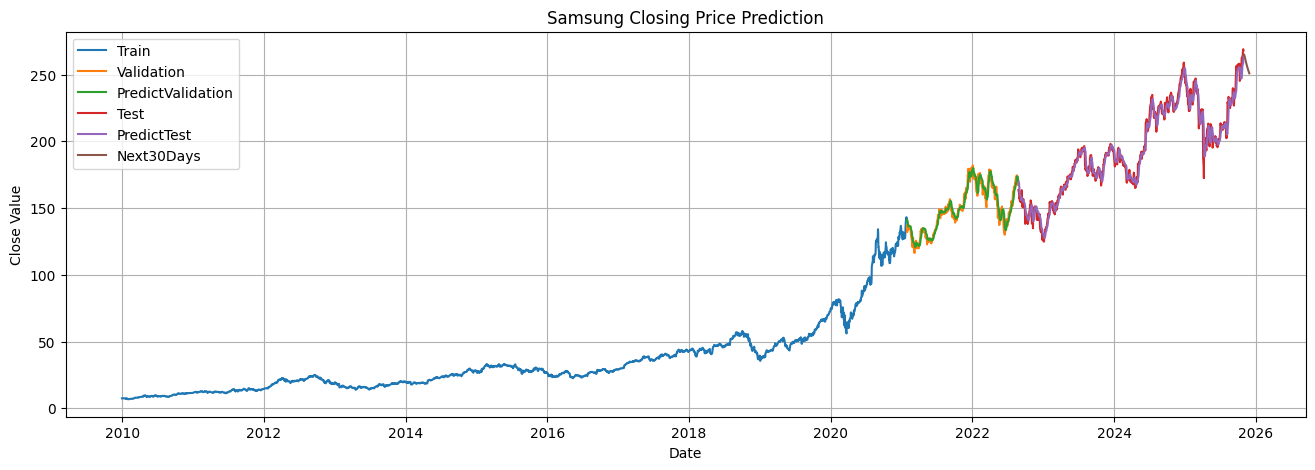

In [68]:
plt.figure(figsize=(16,5))
plt.plot(stock_apple.index[:train_size], train_data_inv)
plt.plot(stock_apple.index[train_size:train_size+val_size], val_data_inv)
plt.plot(stock_apple.index[train_size:train_size+val_size], y_pred_val)
plt.plot(stock_apple.index[train_size+val_size:], test_data_inv)
plt.plot(stock_apple.index[train_size+val_size:], y_pred_test)
plt.plot(future_dates, prediction_next30_days)
plt.xlabel('Date')
plt.ylabel('Close Value')
plt.title('Samsung Closing Price Prediction')
plt.legend(['Train','Validation','PredictValidation','Test','PredictTest','Next30Days'])
plt.grid()
plt.show()